## Linear Regression and Gradient Descent

In this notebook we'll review how to perform linear and regression as an introduction to using Python's numerical library NumPy. NumPy is very similar to MATLAB but is open source and has broader utilitzation in data science than R as many useful tools utilize or are compatible NumPy. To demonstrate, we'll solve the regression problem using a technique called gradient descent with code we write in NumPy, and then with CVX, a powerful optimization library which has a NumPy compatible python API. Becoming comfortable with NumPy opens up a wide range data analysis techniques and visualization tools.

Provided you've installed Jupyter via [Anaconda](https://www.anaconda.com/) the required libraries will be available. Jupyter is a useful development environment for sharing your work in notebooks like the one you're reading. The namespace of an active notebook is persistent across cells and cell executions, so keep track of your variable names! This notebook can be found at [github.com/cpatdowling/ee559/regression.ipynb](https://github.com/cpatdowling/ee559). You can download the repository directly or by using [Git](git@github.com:cpatdowling/ee559.git) (recommended).

### <center> Linear regression </center>

First we'll review [linear regression](https://en.wikipedia.org/wiki/Linear_regression) from a data science perspective. Given some data about the system we're interested in, linear regression will find a linear function which best describes the relationships in the data, for example in Fig. 1. Here data was generated by the function $y = 2x + \epsilon$ where $\epsilon$ is some random noise. Despite the noise in the observations of $(x,y)$, we are still able to observe the line of best fit has a slope $m$ is close to 2, and we could conclude the relationship is governed by the equation $y = mx$. But how do we solve for $m$?

<center>Fig. 1</center>
![alt](figs/linex2.png)

Linear regression works by minimizing a _loss function_ to find the "best fit". A loss function measures the error between a true, known value $y$ and the value of our estimate---the output of the linear model---$\hat{y}$. If the loss function $\mathcal{L}$ is squared error, then for $N$ data samples for example: <p>


<center> $\mathcal{L}(y, \hat{y}) = \sum_{i} (y_{i} - \hat{y}_{i})^{2}$ </center>

then linear regression becomes the familiar method of [least squares](https://en.wikipedia.org/wiki/Least_squares). Let's review ordinary least squares by using NumPy.

In [2]:
#import the required libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Numpy arrays are the object central to most operations. These are just matrices
A = np.array([[0.1, 2],
             [-4, 1.3]])

b = np.array([[0.2],
              [-1.0]])

We can perform matrix operations

$A \cdot b$

In [3]:
print(np.dot(A, b))
print("\n")  #or similarly
print(A.dot(b))

[[-1.98]
 [-2.1 ]]


[[-1.98]
 [-2.1 ]]


And we can solve matrix equations

$Ax = b$<p>
$x = A^{-1}b$

In [4]:
A_inv = np.linalg.inv(A)
x = A_inv.dot(b)
print(x)

[[0.27798278]
 [0.08610086]]


We'll be picking up speed with NumPy techniques relatively quickly. Fortunately there are plenty of resources available to quickly learn Python for computation, or translate functions from a language you know, like R or MATLAB. This notebook should serve as a good self-assesment of your comfort level with data analysis in Python.

See [this handbook](https://jakevdp.github.io/PythonDataScienceHandbook/02.00-introduction-to-numpy.html) for a solid introduction to using NumPy for data science. This book was written by a fellow Husky grad. For those of you familiar with MATLAB, [this cheat sheet](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html) will get you up to speed quickly. Additionally for R, [this table](https://github.com/KirstieJane/datasciencecoursera/wiki/R-vs-Numpy-Cheat-Sheet) will get you started with the basics.

In [5]:
#generate some data

#We use the random module to access random sampling functions
#https://docs.scipy.org/doc/numpy/reference/routines.random.html
#we uniformly sample 1,000, 2 dimensional values between -5 and 5
#this gives a 1000x2 array of values
X = np.random.uniform(-5,5,(1000,2))

#the true model where the output values are perturbed by noise
#reflective of noisy measurements
alpha = np.array([[3.0], 
              [-1.0]])
Y = X.dot(alpha) + np.random.normal(0,1,size=(1000,1))

The array $X$ is 1000 x 2, 1000 rows of samples, each column of the two columns being a _feature_ of the sample. Each row of $Y$ looks like:
    
<center> $y_{i} = \alpha_{1}x_{i,1} + \alpha_{2}x_{i,2} + \epsilon_i$ </center>

or in matrix notation

<center> $Y = Xw + \epsilon$ </center>

and the goal of linear regression is to use the data samples of inputs $X$ and outputs $Y$ to determine the true value of $\alpha = \langle \alpha_1, \alpha_2 \rangle$ with the assumption that the outputs $Y$ are a linear function of the data features $X$. We can look at the data we've generated:

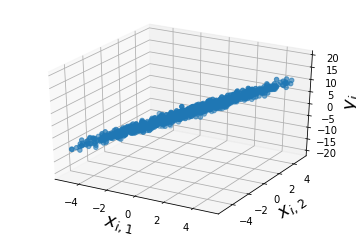

In [6]:
#using matplot lib we scatter plot y_i as a function of x_i,1, x_i,2
from mpl_toolkits.mplot3d import Axes3D #import this so we can plot 3D data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#notice below when we use ":" it allows us to select all the elements along that dimension of the array
ax.scatter(X[:,0], X[:,1], Y[:,])
ax.set_xlabel("$x_{i,1}$", fontsize=18)
ax.set_ylabel("$x_{i,2}$", fontsize=18)
ax.set_zlabel('$y_{i}$', fontsize=18)
plt.show()

This looks a lot like a line, so we'll assume the outputs were generated by a linear function. We'll define the _loss function_ to be squared error, and minimize that loss to find the line of best fit. In other words, we're going to estimate the coefficients of the linear function, $\alpha$ with a vector $\omega$ that gives us the best fit so that $\hat{Y} = X\omega$. Recall that $\hat{Y}$ is our model's guess what $Y$ should be. The error,

<center> $\mathcal{L}(Y, \hat{Y}) = \sum_{i} (y_i - x_{i}\omega_{i})^{2}$ </center>

Alternatively we can write this in matrix notation where $||\cdot||_{2}$ is the 2-norm, or the magnitude of a vector,

<center> $\mathcal{L}(Y, \hat{Y}) = ||Y - X\omega||_{2}^{2}$ </center>

When the samples are vectorized, the sum of squares can be rewritten as,

<center> $\mathcal{L}(Y, \hat{Y}) = (Y - X\omega)^{T}(Y - X\omega)$ </center>
<center> $               = Y^{T}Y - Y^{T}X\omega - (X\omega)^{T}Y + (X\omega)^{T}X\omega$ </center>
<center> $               = Y^{T}Y - Y^{T}X\omega - \omega^{T}X^{T}Y + \omega^{T}X^{T}X\omega$ </center>
<center> $               = Y^{T}Y - 2\omega^{T}X^{T}Y + \omega^{T}X^{T}X\omega$ </center>

Now we'll take the derivative (a gradient vector) of $\mathcal{L}$ with respect to $\omega$:

<center> $\nabla_{\omega} \mathcal{L}(Y, \hat{Y}) = -2X^{T}Y +  2X^{T}X\omega$ </center>

Setting $\mathcal{L} = 0$, we can solve directly for the $\omega$ that minimizes this equation,

<center> $0 = -2X^{T}Y +  2X^{T}X\omega$ </center>
<center> $\omega = (X^{T}X)^{-1}X^{T}Y$ </center>

Taking all the matrix algebra above as is, notice that the weights $\omega$ that minimize the _loss function_ at the last line is just a multiplication problem based on the input data $X$ and output data $Y$ that we have samples of. Let's compute that multiplication problem.

In [7]:
cov = np.dot(X.T, X) #the first half, X.T is the transpose of numpy array X
cov_i = np.linalg.inv(cov) #take the inverse; count your blessings everytime you compute an inverse
right = np.dot(X.T, Y)
omega = np.dot(cov_i, right)

#we can also compute omega using numpy array's builtint dot product method, like this:

omega = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)  #w = (X^T X)^(-1) X^T Y

In [8]:
#check out omega versus alpha
print(omega)
print("\n")
print(alpha)

[[ 2.97811865]
 [-0.9963638 ]]


[[ 3.]
 [-1.]]


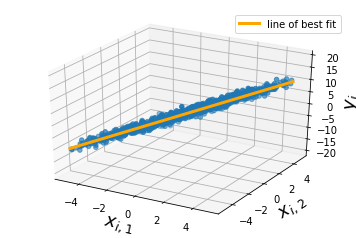

In [9]:
#and we can plot our line of best fit

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_1_ran = np.arange(np.min(X[:,0]), np.max(X[:,1]), 0.1)
x_2_ran = np.arange(np.min(X[:,1]), np.max(X[:,1]), 0.1)
X_ran = np.vstack((x_1_ran, x_2_ran)).T
hat_y = X_ran.dot(omega)  # this is compute the estimate outputs y = Xw

ax.plot(x_1_ran, x_2_ran, hat_y[:,0], color="orange", lw=3, label='line of best fit')
ax.scatter(X[:,0], X[:,1], Y[:,])
ax.set_xlabel("$x_{i,1}$", fontsize=18)
ax.set_ylabel("$x_{i,2}$", fontsize=18)
ax.set_zlabel('$y_{i}$', fontsize=18)
ax.legend()

plt.show()

### <center> Gradient Descent </center>

Recall above that we needed to compute the derivate of the loss function with respect to the weights $\omega$. This is a core task to all forms of machine learning. It just so happens that in the case of linear regression, where we assume that outputs $Y$ are a linear function of the inputs and the weights, $X\omega$, that we can find a _closed form_ solution to the best weights to use. Closed form means like above; I can rearrange the symbols so that $\omega$ is on the left hand side, and values I know are on the right hand side.

This isn't always the case. Once we choose a loss function and compute the derivative of the loss with respect to the weights, we may find we may not be able to write an equation we can solve directly. What exactly did we do when we computed $\nabla_{\omega}\mathcal{L}$? This is the gradient of the loss---the error in our estimate---with respect to the weights. This means if I change the value of the weights along the _direction_ of this gradient vector, then my loss should decrease! Lets try it out.

Recall we computed the gradient to be,

<center> $\nabla_{\omega} \mathcal{L}(Y, \hat{Y}) = -2X^{T}Y +  2X^{T}X\omega$ </center>
<center> $\nabla_{\omega} \mathcal{L}(Y, \hat{Y}) = 2X^{T}(X\omega - Y)$ </center>

we can define an iterative method to move the value of $\omega$ by a small amount in the negative direction of $\nabla_{\omega} \mathcal{L}(Y, \hat{Y})$.

<center> $\omega_{next} = \omega_{prev} - \eta \nabla_{\omega} \mathcal{L}$ </center>

where $\eta$ is the small amount we move in the direction of $\nabla_{\omega} \mathcal{L}$ by, and we continually update $\omega$ until it doesn't change anymore. We have the benefit of knowing there is only one unique solution to the least squares problem, and for now we don't have to worry about potential pitfalls.

In [25]:
w_prev = np.random.normal(0,1,size =(2,1)) #pick a random place to start w and store previous values
w_next = np.zeros((2,1))                   #initialize a variable to iterate the next value with
step_size = 0.0001                         #this is how much we update w by

i = 0
max_iter = 10000                           #a maximum number of iterations will be our stopping criterion

while i < max_iter:
    w_next += step_size*2*X.T.dot(Y - X.dot(w_next))
    i += 1

ValueError: shapes (100,) and (2,1) not aligned: 100 (dim 0) != 2 (dim 0)

In [11]:
print(w_next)
print("\n")
print(alpha)

[[ 2.97811865]
 [-0.9963638 ]]


[[ 3.]
 [-1.]]


### What can go wrong?

Here we generate the data seen in Fig. 1 and compare it what happens when we attempt to use linear regression on a function that <emph>isn't</emph> lienar.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

X_poly = np.random.normal(0,1,size=(100,1))                 #generate a bunch of randomly selected X's
Y_poly = 2*np.power(X_poly,2) + np.random.normal(0,1,size=(100,1))  #Y = x^{2} + noise ---- a non linear function of X

X_lin = np.random.normal(0,1,size=(100,1))             #generate a bunch of randomly selected X's
Y_lin = 2*(X_lin) + np.random.normal(0,1,size=(100,1)) #Y = 2x + noise

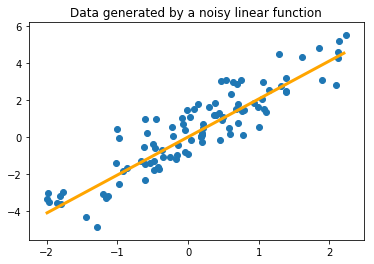

In [36]:
#here we solve for and plot the line of best fit for the linear function data

w = (1.0/np.dot(X_lin.T, X_lin))[0,0]*X_lin.T.dot(Y_lin)[0,0] #closed form OLS solution for single dim

plt.plot(np.arange(np.min(X_lin),np.max(X_lin),0.1), w*np.arange(np.min(X_lin),np.max(X_lin),0.1), color="orange", lw=3)
plt.title("Data generated by a noisy linear function")
plt.scatter(X_lin, Y_lin)
plt.show()

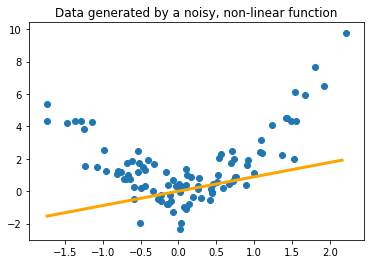

In [37]:
#here we solve for and plot the line of best fit for the non-linear function data

w = (1.0/np.dot(X_poly.T, X_poly))[0,0]*X_poly.T.dot(Y_poly)[0,0]

plt.plot(np.arange(np.min(X_poly),np.max(X_poly),0.1), w*np.arange(np.min(X_poly),np.max(X_poly),0.1), color="orange", lw=3)
plt.title("Data generated by a noisy, non-linear function")
plt.scatter(X_poly,Y_poly)
plt.show()

Notice that we can still find a line of best fit that minimizes the loss function. The underlying function is polynomial, however, and not linear, so we might need to use a different basis function. The term linear in linear regression implies that the basis function of the system is linear. We could also try polynomial regression. This is why gradient descent is useful; not all basis functions give us a closed form solution like in the case of linear regression, but we can always minimize the squared loss given a differentiable basis function. The challenge is then choosing the correct basis function. We'll be diving much deeper into this as the course progresses.

In [39]:
#using the same gradient descent code from the above example

w_next = np.random.normal(0,1,size=(1,1))  #pick a random place to start w and store previous values
step_size = 0.0001                         #this is how much we update w by

i = 0
max_iter = 10000                           #a maximum number of iterations will be our stopping criterion

while i < max_iter:
    w_next += step_size*2*np.power(X_poly,2).T.dot(Y_poly - np.power(X_poly,2).dot(w_next)) #the polynomial basis function x^{2}
    i += 1

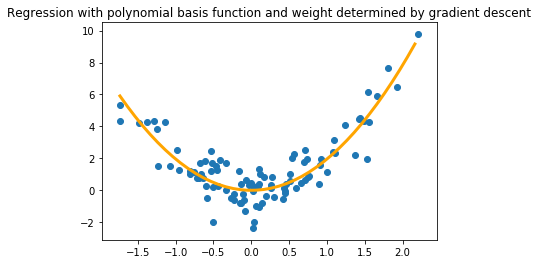

In [47]:
plt.plot(np.arange(np.min(X_poly),np.max(X_poly),0.1), (w_next*np.power(np.arange(np.min(X_poly),np.max(X_poly),0.1),2))[0,:], color="orange", lw=3)
plt.title("Regression with polynomial basis function and weight determined by gradient descent")
plt.scatter(X_poly,Y_poly)
plt.show()

### Assignment questions

In the above examples, all of the noise was generated with Gaussian noise. Try selecting another random distribution, generate some data, and find the line of best fit. For the same number of samples, how does the outcome change, if at all, when the noise is Gaussian?

In [59]:
#insert your code here



Oftentimes our data will have outliers, genrated by faulty sensor measurements or random fluctuations caused by something external to the system we're analyzing. Here we generate some data with a large outlier. Find the line of best fit for the data with the outlier and without the outlier using the ordinary least squares solution and discuss why the results look different. Describe what we could do to deal with the outlying data?

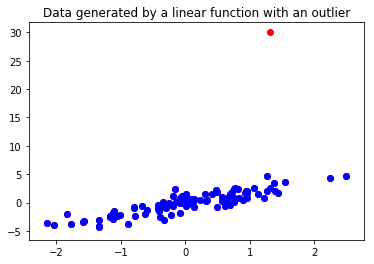

In [62]:
import copy

X_h = np.random.normal(0,1,size=(100,1))             #generate a bunch of randomly selected X's
Y_h = 2*(X_h) + np.random.normal(0,1,size=(100,1))   #Y = 2x + noise

Y_outlier = copy.copy(Y_h)                           #create a copy of the original Y vector 
Y_outlier[15] = 30.0                                 #the new outlier value is much larger than the rest

plt.title("Data generated by a linear function with an outlier")
plt.scatter(X_h, Y_outlier, color="red")
plt.scatter(X_h, Y_h, color="blue")
plt.show()

In [63]:
#find the ordinary least squares solution to the data X_h and Y_h, 
#and then the ordinary least squares solution to X_h and Y_outlier, 
#then plot the two lines to compare them. What happens? Notice that
#Y_outlier is identical to Y_h except for a single value




We've generated some data with an unknown basis function. Your job is to select what you think the basis function is, and use gradient descent to learn the appropriate weight to find the line of best fit for the data. Below is some code to load and plot the data to get you started.

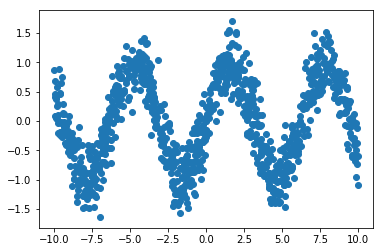

In [64]:
#load the data
data = np.loadtxt("homework_1_data.txt")
X_b = data[:,0]
Y_b = data[:,1]

#plot the data
plt.scatter(X_b, Y_b)
plt.show()

In [ ]:
#hint, in the gradient descent loop, incorporate the 
#basis function of X into the derivative of the loss function
#you'll still need to fill in the rest of the gradient descent
#algorithm as well

w_next += step_size*2*basis_function(X).T.dot(Y - basis_fuction(X).dot(w_next))